In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
import numpy as np
np.random.seed(44)


In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [12.0, 5.0],
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Gaussian and robust models


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on.. 


*   Chapter 2 of O. Martin, *Bayesian Analysis with Python, Second Edition*.

*  Notebook by G. Corani

# Multiparameter models

* Usually a probabilistic model contains multiple parameters.

* Not all  parameters  are of interest.  If we want to estimate the mean value of a Gaussian distribution the model must contain a parameter for the mean and one for the standard deviation. 

* Parameters that are not of immediate interest but are necessary to  define the model are called *nuisance parameters*.

* By modelling the nuisance parameters we allow the uncertainty  about them to propagate appropriately to the results. 

# TODO 
* aggiungere un paio di quiz your self
* possiamo fare calcolare a mano il posterior predictive check? ma non so come accedere ai valori campionati nella traccia

#  Inference about the speed of light

* At the end of the 19th century Simon Newcomb carried out several experiments to determine the speed of light.
* In each of them, Newcomb measured the time it took for light to travel 7,442 meters.
* The data seems to be normally distributed, apart from some low values far from the mean.


In [3]:
#Below is the results of  66 measurements.

data = np.array([248.28, 248.26, 248.33, 248.24, 248.34, 247.56, 248.27, 248.16,
                  248.4, 247.98, 248.29, 248.22, 248.24, 248.21, 248.25, 248.3,
                  248.23, 248.29, 248.31, 248.19, 248.24, 248.2, 248.36, 248.32,
                  248.36, 248.28, 248.25, 248.21, 248.28, 248.29, 248.37, 248.25,
                  248.28, 248.26, 248.3, 248.32, 248.36, 248.26, 248.3, 248.22,
                  248.36, 248.23, 248.27, 248.27, 248.28, 248.27, 248.31, 248.27,
                  248.26, 248.33, 248.26, 248.32, 248.32, 248.24, 248.39, 248.28,
                  248.24, 248.25, 248.32, 248.25, 248.29, 248.27, 248.28, 248.29,
                  248.16, 248.23])


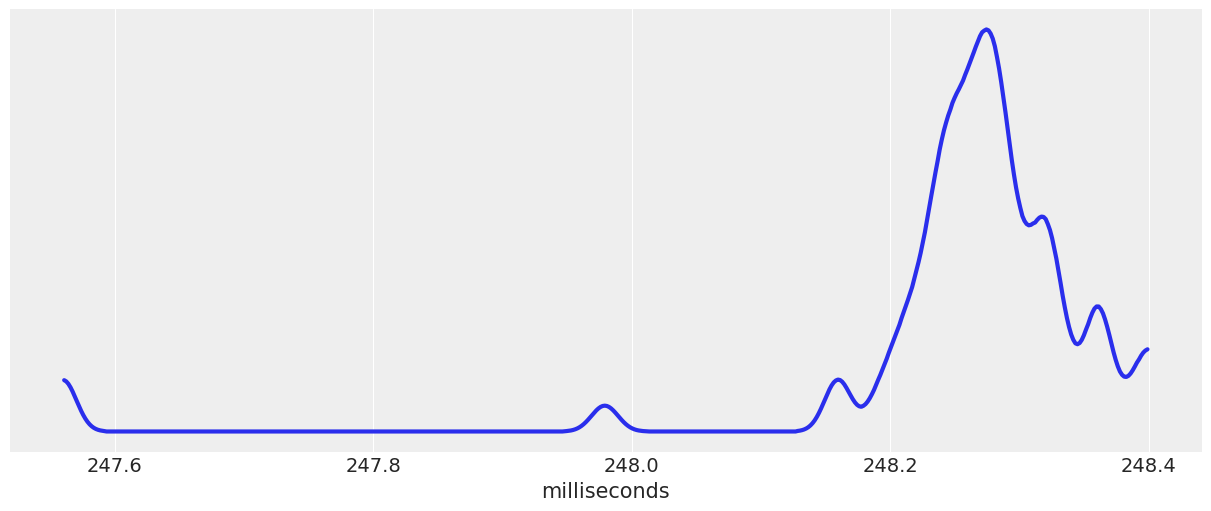

In [4]:
#the density plot is called kde (kernel density estimation)
az.plot_kde(data, figsize=[12,5])
plt.yticks([])
plt.xlabel('milliseconds');

# Gaussian model

* The uncertainty due to measurements error is often Gaussian distributed.

* A Gaussian distribution is defined by  the mean $\mu$ and the standard deviation $\sigma$. 

* We  assign priors to $\mu$ and $\sigma$ to make inference about  them.

# Prior distribution of $\mu$

Before seeing the data, we formalize our (possibly vague) prior belies about the parameters:

* we do not know the exact value of $\mu$, but we can provide an interval which in our opinion contains it with high probability
    * we can assume that   $\mu$ lies within the interval ($l$, $u$).  with  95% probability 
    * The 95% interval of a Gaussian  is approximately  $\mu \pm 2 \sigma$
    * The 99% interval of a Gaussian is approximately $\mu \pm 3 \sigma$
   
## Example  

* If our 95% prior interval for $\mu$ is [0,20]:
    our prior for $\mu $ can be $\mu \sim N(10, 5)$

* If our 99% prior interval for  $\mu$ is [0,60]:
    our prior for $\mu $ can be $\mu \sim N(30, 10)$




# Prior distribution of $\sigma$

* A typical prior for  $\sigma$ is the *half-normal* distribution. 
* $\sigma$ is striclty positive.
* The half-normal is  a Gaussian  restricted to positive values . 
* You sample from a half-normal by sampling from a normal distribution and rejecting the negative values (or applying the absolute value to the  sampled values).





# slide aggiuntiva sulla halfnormal distribution

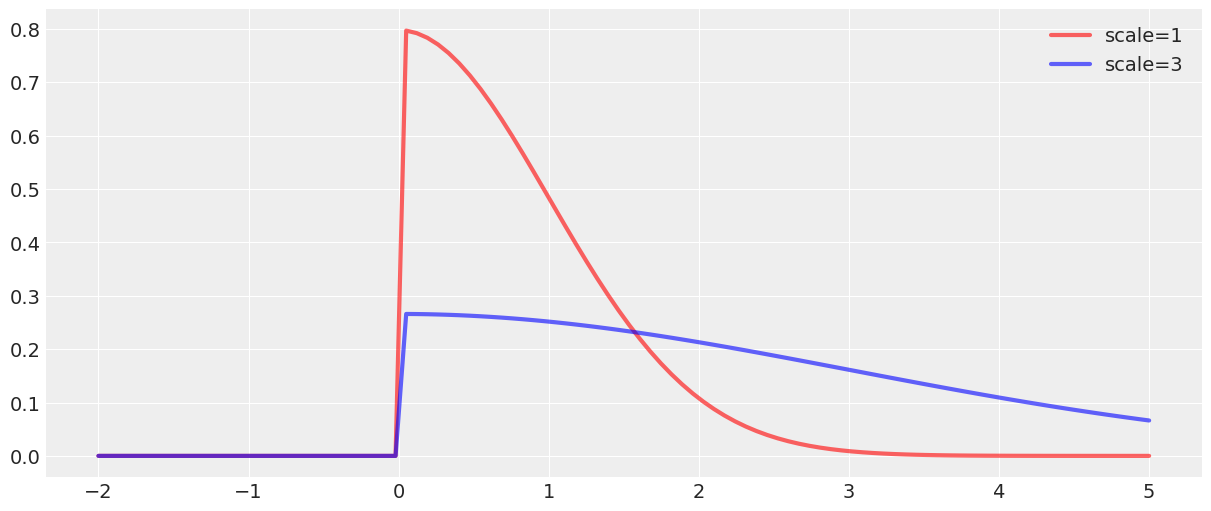

In [5]:
from scipy.stats import norm
from scipy.stats import halfnorm
fig, ax = plt.subplots(1, 1)

x = np.linspace(-2,5, 100)

#at each x we plot the pdf of the halfnorm with different scales
ax.plot(x, halfnorm.pdf(x, scale=1), 'r-', lw=3, alpha=0.6, label='scale=1')
ax.plot(x, halfnorm.pdf(x, scale=3), 'b-', lw=3, alpha=0.6, label='scale=3');
ax.legend();


# Prior distribution of $\sigma$

* You might have a plausible value for the standard deviation of the noise, and match it with the median of the half-normal distribution.


* You can adjust  with the scale of the  half-normal distribution to obtain a distribution whose median is close to our guess.


* The distribution is long-tailed and thus it is a safe choice  even if your median guess is underestimated. 


* The prior should cover a wide range of plausible values for $\sigma$, leaving out however values that make no sense.

In [6]:
# Assume  we think a plausible value for the standard deviation of the noise is 7.5.
# That is, with 95% probability the measures are corrupted by an amount of noise betwen +- 15.
#The halfnormal distribution below has median of about 7.5; this has been obtained by trying different values of the scale parameter.
#This is thus a reasonable prior.
#Notice the long tails of the distribution, which allows to model to correct in case our guess is underestimated.  
pd.DataFrame(halfnorm.rvs(size=1000, scale=11)).describe()

,0
count,1000.000000
mean,8.802740
std,6.646881
min,0.008884
25%,3.730874
50%,7.462435
75%,12.302741
max,33.810577


# Your turn

* Try to define the priors of a probabilistic model which  represents the distribution of height of adult males in Switzerland 

# The probabilistic model: priors and likelihood

\begin{align}
y & \sim \mathcal{N}(\mu, \sigma) && \text{the observation are  affected by a noise with standard deviation } \sigma\\
\mu &\sim N(\mu_{\mu}, \sigma_{\mu}) && \text{prior beliefs about } \mu\\ 
\sigma &\sim \text{Half-Normal}(\sigma_{\sigma}) && \text{prior beliefs about } \sigma \\
\end{align}

# The probabilistic model of height

* We  need  specifying priors for $\mu$ and $\sigma$.


* We think that the mean height of the population could  be 175, though this is uncertain. Keeping our prior broad, we state that the mean height of the population lies with 99% probability between 160 and 190 cm.
  * $\mu \sim \mathcal{N}(175, 5)$ 
  

* We shall now assign a prior to $\sigma$. We assume that within the whole population the height  varies with 99% probability between 100 and 250. Hence the corresponding value of the standard deviation is (250-100)/6 = 25.

    * A half-normal distribution with scale 35 has roughly this median:
       * $\sigma \sim \text{Half-Normal}(35) $


* The likelihood  $y  \sim \mathcal{N}(\mu, \sigma)$ requires no further specification. 

In [7]:
pd.DataFrame(halfnorm.rvs(size=1000, scale=35)).describe()

,0
count,1000.000000
mean,28.328387
std,21.396510
min,0.029919
25%,11.787456
50%,23.042191
75%,40.437541
max,124.554540


# Back to the example of light speed, alternative prior for $\mu$ 

\begin{align}
y & \sim \mathcal{N}(\mu, \sigma)\\
\mu &\sim U(l, h) \\
\sigma &\sim \text{Half-Normal}(\sigma_{\sigma}) \\
\end{align}

* We use  priors that reflect our ignorance  about $\mu$ and $\sigma$.

* For the  uniform distribution, we could use:
    * $l$ = 0  (speed cannot be negative)
    * $u$ = 1000 milliseconds (high on the data scale). 

# Back to the example of light speed, alternative (but not recommended) prior for $\mu$

If we have no idea about the possible location of $\mu$, we can use a uniform prior over a large interval: 
\begin{align}
\mu &\sim U(l, h) \\
\sigma &\sim \text{Half-Normal}(\sigma_{\sigma}) \\
y & \sim \mathcal{N}(\mu, \sigma)
\end{align}


* For instance:
    * $l=data.min() / 5$
    * $h=l+data.min() * 5$. 
    
    
* In this way the prior is  much broader then the data.

* However, whenever possible  do **not** use the data to define the prior.
* Also, avoid prior with sharp limits, which can  make the sampling problematic.
* Prior with sharp limits are appropriate only if the variable is truly defined over an interval: for instance the bias $\theta$ of the coin is bounded in (0,1) and thus the Beta is an appropriate distribution.

# Implementation

In [24]:
with pm.Model() as model_newcomb:
    #prior for the location of mu
    # Based on our experience, we  believe  mu to lie with very high probability (99%) in (0, 480).
    # This corresponds to a normal distribution with mu = 240 (mid-point of the interval), sigma = 80 
    # obtained as ( (480- 0) / 6)
    # Of course the choice of the prior is subjective. In case of doubt, the important is to have a prior covering a   broad range.
    mu = pm.Normal('mu', 240, 80)
    
    #According to our experience, a plausible value for the standard deviation of the noise is 2.
    # the median sigma according to the distribution below  is about 2.
    sigma = pm.HalfNormal('sigma', sd=3)

    
    #likelihood. Each observation is a sample from N(mu, sigma).
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    
    trace_newcomb = pm.sample()

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


# Inspecting the trace 


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


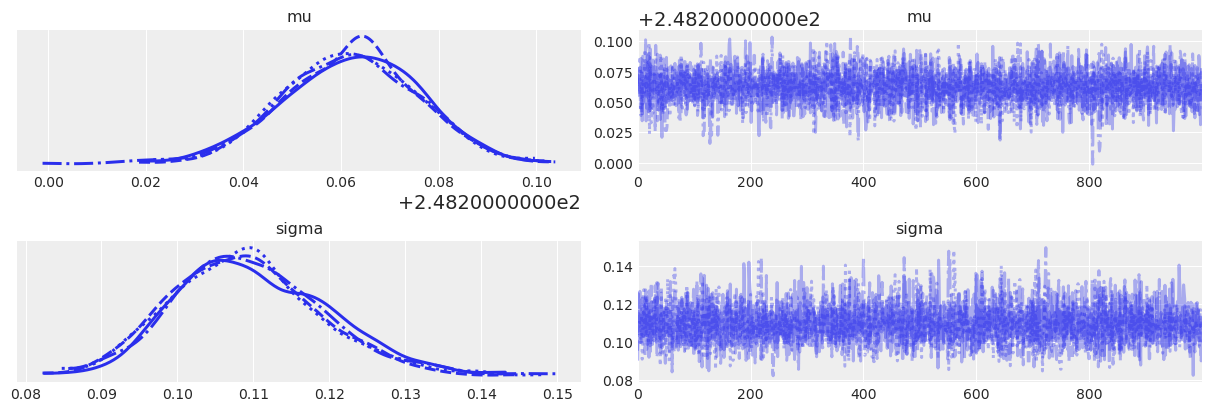

In [25]:
# The traceplot now has two rows: one for each parameter.
#The posterior is  two-dimensional; each  row corresponds to a marginal variable of the posterior.
#The samples are representative as shown by smooth density plot and well-mixing chains.
az.plot_trace(trace_newcomb);

In [26]:
az.summary(trace_newcomb) 

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,248.262,0.014,248.237,248.288,0.0,0.0,3478.0,2499.0,1.0
sigma,0.109,0.010,0.091,0.127,0.0,0.0,3203.0,2552.0,1.0


# What if we change the prior?

In [11]:
with pm.Model() as model_newcomb_2:

    #mu = pm.Normal('mu', 240, 80)
    #we have different beliefs about mu; larger mean and larger uncertainty.
    mu = pm.Normal('mu', 300, 100)
    
    #identical to the previous model
    sigma = pm.HalfNormal('sigma', sd=3)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    
    trace_newcomb_2 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [12]:
# inference remain practically the same under the two different priors.
# This is very good: the data are strong enough to converge even from significantly different priors.
# The likelihood overwhelms the prior; the results are thus robust to the specification of the prior.


a = az.summary(trace_newcomb) 
b = az.summary(trace_newcomb_2) 
pd.concat([a,b])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,248.262,0.013,248.236,248.287,0.0,0.0,3443.0,2435.0,1.0
sigma,0.110,0.010,0.092,0.129,0.0,0.0,3682.0,2743.0,1.0
mu,248.262,0.013,248.238,248.288,0.0,0.0,3132.0,2475.0,1.0
sigma,0.109,0.010,0.092,0.129,0.0,0.0,3453.0,2367.0,1.0


# Posterior prediction

* Suppose you carry out a new measurement.  Make a prediction about its value based on the posterior.
* The simples answer is to use the posterior mean, 248.262 according to the summary in the previous slide.

* Yet  this singular prediction ignores two  sources of variability:

    * the effect of the noise
    * posterior variability of $\mu$ and  $\sigma$. 

* We should consider the entire of plausible values contained in the posterior sampels, to quantify the uncertainty of our prediction.

# Posterior prediction

* The trace contains some thousands parameter samples  $<\mu_i, \sigma_i >$. 


* This is a numerical approximation for the posterior density of $\mu$ and $\sigma$, which is untractable.


* Based on this sample,  the probabilistic prediction for the next observation is computed  by simulating a measurement prediction for each parameter set:

$$
Y_{\text{new}}^{(i)} | \mu_i, \sigma_i  \; \sim \; N\left(\mu_i, \sigma_i\right)$$



# Posterior prediction

We can 
* Each parameter sample  produces a different prediction.

$$
\left[
\begin{array}{ll} 
\mu^{(1)} &   \sigma^{(1)} \\
\mu^{(2)} & \sigma^{(2)} \\
\vdots & \vdots & \vdots \\
\mu^{(4000)}  & \sigma^{(4000)} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
Y_{\text{new}}^{(1)} \\
Y_{\text{new}}^{(2)} \\
\vdots \\
Y_{\text{new}}^{(4000)} \\
\end{array}
\right]
$$

The resulting collection of 4,000 predictions $Y_{\text{new}}$ approximates the posterior prediction for a new measurement, accounting for our uncertainty. 

# Posterior prediction

* Each parameter sample  produces a different prediction.

$$
\left[
\begin{array}{ll} 
\mu^{(1)} &   \sigma^{(1)} \\
\mu^{(2)} & \sigma^{(2)} \\
\vdots & \vdots & \vdots \\
\mu^{(4000)}  & \sigma^{(4000)} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
Y_{\text{new}}^{(1)} \\
Y_{\text{new}}^{(2)} \\
\vdots \\
Y_{\text{new}}^{(4000)} \\
\end{array}
\right]
$$

The resulting collection of 4,000 predictions $Y_{\text{new}}$ approximates the posterior prediction for a new measurement, accounting for our uncertainty. 

In [13]:
# we compute the posterior prediction by adding a single line to our pymc3 code.
# it could be possible to obtain the same result by extracting samples from the trace, but I was unable to do that.
with pm.Model() as model_newcomb:
    #model as before (first variant)
    mu = pm.Normal('mu', 240, 80)
    sigma = pm.HalfNormal('sigma', sd=3)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    
    #prediction
    prediction = pm.Normal('prediction', mu=mu, sd=sigma)
        
    trace_newcomb_pred = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prediction, sigma, mu]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [14]:
az.summary(trace_newcomb_pred, var_names='prediction')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prediction,248.262,0.111,248.055,248.469,0.002,0.001,4701.0,2607.0,1.0


# Checking the model: posterior predictive checks

See https://www.bayesrulesbook.com/chapter-9.html#chapter-9-prediction

* It is possible that the sampling of a model has converged correctly, yet the model is  entirely unsuitable.

* Posterior predictive check ensure that the estimated model adequately fits the data.

* Idea: make prediction using the posterior of the parameters;  the distribution of the simulated data should resemble the distribution of the actual data.

Denoting the simulated  data as $\tilde{y}$ and the model parameters as $\theta$:

\begin{align}
\underbrace{p(\tilde{y} \,|\, y)}_{\text{distribution of data simulated from the fitted model}} & 
= \int p(\tilde{y} \,|\, \theta) \, p(\theta \,|\, y) \, d\theta \\
\end{align}


where:

* $y$ is the observed data 
* $\theta$ corresponds to the model parameters: $\theta = [\mu, \sigma]$ in our example.

# Posterior predictive checks

* We typically need  few samples for computing PPC relative to the MCMC sample.
 
We compute  $\tilde{y}$ as follows:

1. We randomly choose an index of the `trace` generated by PyMC3 (a value for $\mu_i$ and $\sigma_i$)
2. We generate a _synthetic data_ using the same _likelihood_ we used in the model, in this case $\tilde{y_i} \sim N(\mu_i, \sigma_i)$
3. We repeat 1 and 2 until we obtain the required number of samples.

* PPCs allow validating a model  and revising if necessary.


In [27]:
with model_newcomb:
    # select 500 samples <mu_s ,sigma_s> from the trace
    # for each samples, compute a draw N(mu_s ,sigma_s) 
    # The ppc variable is a dictionary, with the keys being the name of the observed variable in our model and the values an array of shape (samples, size). 
    # The dictionary allows dealing with models with more than one observed variable. 
    ppc = pm.sample_posterior_predictive(trace_newcomb, samples=500)

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


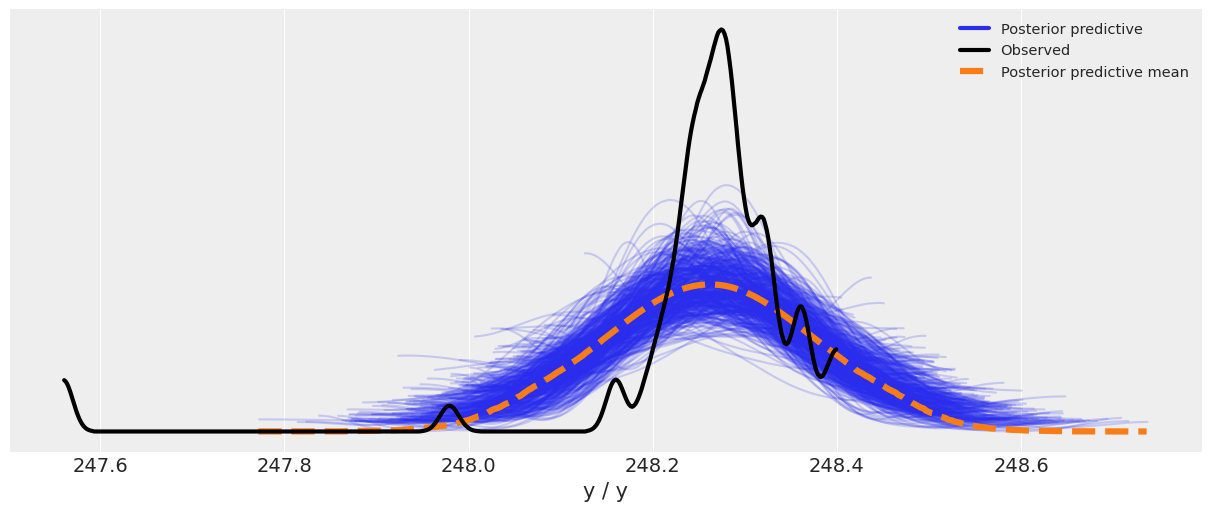

In [23]:
# the density reproduced by the model is too low around the center and does cover the long left tail adequately.
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model_newcomb));

#  Robust models

* The previous model  assumes a normal distribution of the measures but there are  outliers which are  far from the mean values. 

* These points could be due to experimental errors. If we are sure that this is the case,  we could remove them from our dataset (leaving a record of the removal and the reasons why we did it). 

* A more principled approach option is to adopt a likelihood which is *robust* to outliers.

#  The normal distribution has light tails

* The normal distribution is very sensitive to outliers. 

* The probability of finding a value falls rapidly as we move away from the mean, to become practically negligible when we are more than 3 standard deviation from the mean.

* If the data contains observations which are even further from the mean, the normal distribution is not a good model. 

* In table we show the probability of lying *outside* the region $\mu \pm k \sigma$:
    * $P = P( x < \mu - k \sigma) +  P(x > \mu + k \sigma) $ 

| k |   \begin{equation} P \end{equation}|
|:-:|-:-|
| 1 |  0.3173 |
| 2 | 0.0455  |
| 3 | 0.0026 |
| 4 | 0.00006 |

# Student's t distribution


<img src='img/Student_t.png' width=400 align="center" > 

* It is defined by a mean, a scale $\sigma$ (related to the spread of the distribution) and by $\nu$ (referred to as *degrees of freedom* in the literature of hypothesis testing).

*  $\nu$ controls how _heavy_ the tails of the distribution are. 

    *  $\nu > 30$: the Student is practically equivalent to a Gaussian. 

    * $\nu = 4$ is a common choice to have a robust model with heavy tails, which can model observations that are far away from the mean.

# Comparing the normal and the t distribution ($\nu$=4)


* Probability of lying *outside* the region $\mu \pm k \sigma$:
    * $P = P( x < \mu - k \sigma) +  P(x > \mu + k \sigma) $ 

| k |   Normal | t ($\nu$=4)
|:-:|-:-|-:-|    
    | 1 |  0.32 | 0.38    |
    | 2 | 0.04 |  0.12 | 
    | 3 | 0.002 | 0.04 |
    | 4 | 0.00006 | 0.02 |
    
* The 99% interval is defined as:

    * $\mu \pm 2.58 \sigma$ for the normal distribution;
   
    * $\mu \pm 4.61 \sigma$ for the t distribution ($\nu$=4)

# Robust probabilistic model
The following model is able to deal with observation which are farther than 4 standard deviations from the mean:


\begin{align}
y & \sim StudentT (\mu, \sigma \nu=4) && \text{the observation are  allowed to contain outliers}\\
\mu &\sim N(\mu_{\mu}, \sigma_{\mu}) && \text{prior beliefs about } \mu\\ 
\sigma &\sim \text{Half-Normal}(\sigma_{\sigma}) && \text{prior beliefs about } \sigma \\
\end{align}

* More sophisticated approaches would try to learn $\nu$ from data, by assining a prior to it.

In [39]:
with pm.Model() as model_t:
    #the priors are the same as those of  the first variant
    mu_t      = pm.Normal('mu', 240, 80)
    sigma_t = pm.HalfNormal('sigma', sd=3)

    #robust likelihood
    y              = pm.StudentT('y', mu=mu_t, sd=sigma_t, nu=4, observed=data)

    #prediction for a new measurement
    #prediction = pm.StudentT('prediction', mu=mu_t, sd=sigma_t, nu=4)
        
    trace_t = pm.sample() 

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [42]:
# Let us compare the estimates of the two models
with model_t:
    summary_t = az.summary(trace_t)
with model_newcomb:
    summary= az.summary(trace_newcomb)
pd.concat([summary_t, summary])[ ["mean","sd" ]]

,mean,sd
mu,248.275,0.007
sigma,0.047,0.006
mu,248.262,0.014
sigma,0.109,0.010


# Estimates comparison

* The estimation of $\mu$ is identical for the normal and the t model.

* But the t model  estimates a much lower  $\sigma$  (about half) compared to the normal model. This is a consequence of the t- distribution giving less weight (being less surprised) by values away from the mean. 

* This allows keeping higher the density around the bulk of the data.

* Let us perform a posterior predictive check.

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<AxesSubplot:xlabel='y / y'>

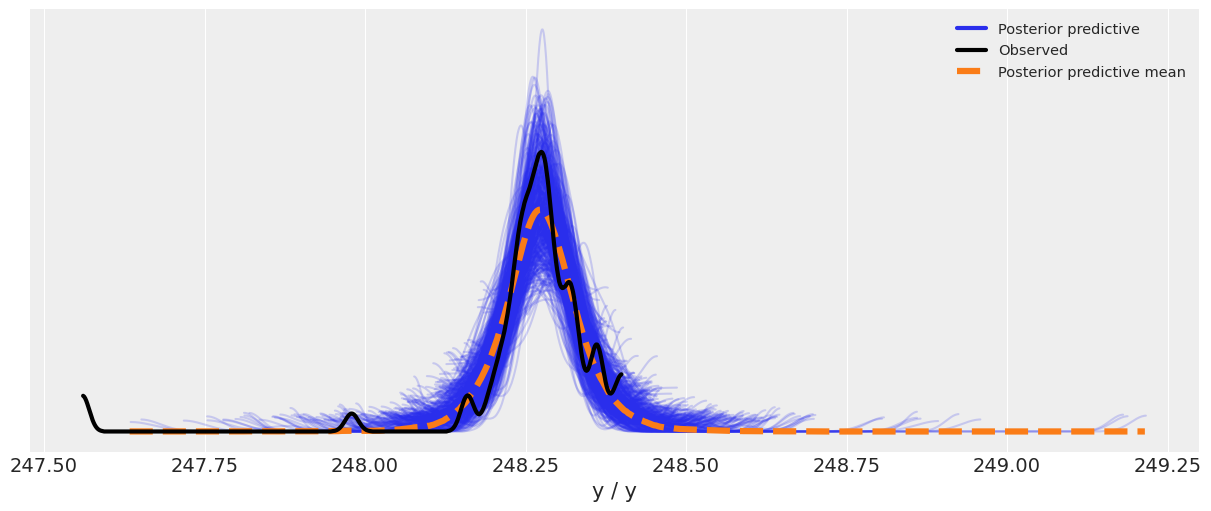

In [46]:
with model_t:
    ppc_t = pm.sample_posterior_predictive(trace_t, samples=500)
    
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_t, model=model_t))

# Exercises

*  Replace the beta distribution with a uniform one on the interval [0, 1]. How does the sampling rate change? What if you use a wider range, like [-3, 3]?


*  For the `model_g`. Use a Gaussian for the mean, centered at the empirical mean. Try modifying the standard deviation of that prior. How robust/sensitive are the results to the choice of prior?


* The Gaussian is a distribution _without limits_ that is, it is valid in the interval $[-\infty, \infty]$, in the previous example we use it to model data that we know have limits. What do you think of this choice?


* Using the speed of light data, calculate the mean and standard deviation with and without the _outilers_, compare those values ​​with those obtained with the `model_g` and with the `model_t`.
